# This notebooks shows how to generate and score sequences with all possible 3 mutations
#### It uses the synthetic sequences file generated via FLY_KC_EFS notebook.
#### It consists of:
* Generating sequences with all possible 3 mutations
* Comparing prediction scores
#### Figures are saved to ./figures/mutation_combination

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading the model

In [2]:
print('Loading model...')
import shap
tf.disable_eager_execution()
model_dict = {}
name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)

Loading model...


### Loading the generated sequences via in silico evolution¶

In [4]:
import pickle
f = open("data/deepflybrain/FLY_KC_EFS_6000_withmut.pkl", "rb")
evolved_seq_6000_dict = pickle.load(f)
f.close()

### Following code generates sequences with all possible 3 mutations starting from a single random sequence

In [ ]:
from itertools import combinations, combinations_with_replacement, product
location_combinations = list(combinations(list(range(500)), 3))
nucleotide_combinations = list(product(range(3), repeat = 3))

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}
def create_possible_single_mutations(onehot):
    mutagenesis_X = {"loc":[],"nuc_onehot":[]}
    for mutloc,nt in enumerate(onehot):
        new_X = np.copy(onehot)
        if list(nt) == [1, 0, 0, 0]:
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["nuc_onehot"].append(np.array([0, 1, 0, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 0, 1, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 0, 0, 1], dtype='int8'))
        if list(nt) == [0, 1, 0, 0]:
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["nuc_onehot"].append(np.array([1, 0, 0, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 0, 1, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 0, 0, 1], dtype='int8'))
        if list(nt) == [0, 0, 1, 0]:
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["nuc_onehot"].append(np.array([1, 0, 0, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 1, 0, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 0, 0, 1], dtype='int8'))
        if list(nt) == [0, 0, 0, 1]:
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["loc"].append(mutloc)
            mutagenesis_X["nuc_onehot"].append(np.array([1, 0, 0, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 1, 0, 0], dtype='int8'))
            mutagenesis_X["nuc_onehot"].append(np.array([0, 0, 1, 0], dtype='int8'))
            
    mutagenesis_X["loc"] = np.array(mutagenesis_X["loc"])
    mutagenesis_X["nuc_onehot"] = np.array(mutagenesis_X["nuc_onehot"])
    return mutagenesis_X 
    
id_ = 35
start_x = np.copy(evolved_seq_6000_dict["X"][id_])
all_possible_single_mutation_onehot = create_possible_single_mutations(start_x)['nuc_onehot']

In [ ]:
# import pickle

# for out_of_27 in range(27):
#     mutatated_seqs = np.zeros((20708500,500,4))
#     for nuc_ in [nucleotide_combinations[out_of_27]]:
#         for i,loc_ in enumerate(location_combinations):
#             new_X = np.copy(start_x)
#             for mut_index in range(3):
#                 new_X[loc_[mut_index],:] = all_possible_single_mutation_onehot[loc_[mut_index]*3 + nuc_[mut_index]]
#             mutatated_seqs[i] = new_X
#     pred_ = model_dict["DeepFlyBrain"].predict(mutatated_seqs)
    
#     f = open("data/all_possible_3_mut/pred_"+str(out_of_27+1)+"_27.pkl", "wb")
#     pickle.dump(pred_, f ,protocol=4)
#     f.close()

In [5]:
preds = []
for i in range(27):
    f = open(".data/all_possible_3_mut/pred_"+str(i)+"_27.pkl", "rb")
    pred_ = pickle.load(f)
    preds.append(pred_)
    f.close()

### Number of sequences with higher prediction scores compared to sequence following the greedy search path

In [7]:
np.sum(KC_pred>evolved_seq_6000_dict['mut_pred'][[35],3,34])

7

### Plotting prediction score distribution of the generated sequences with all possible 3 mutations

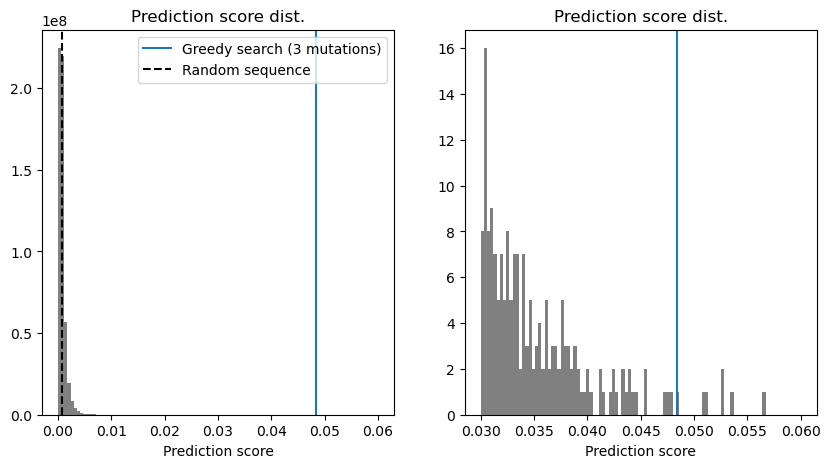

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)

_ = plt.hist(KC_pred,bins=100,range=[0,0.06],color='gray')
plt.axvline(evolved_seq_6000_dict['mut_pred'][[35],3,34],label="Greedy search (3 mutations)")
plt.axvline(evolved_seq_6000_dict['mut_pred'][[35],0,34],label="Random sequence",color='black',linestyle='--')

plt.legend()
plt.title("Prediction score dist.")
plt.xlabel("Prediction score")

ax = fig.add_subplot(1,2,2)

plt.hist(KC_pred,bins=100,range=[0.03,0.06],color='gray')
plt.axvline(evolved_seq_6000_dict['mut_pred'][[35],3,34],label="Greedy search")
plt.title("Prediction score dist.")
plt.xlabel("Prediction score")

plt.savefig("figures/mutation_combination/EFS4_3Steps_allpossiblemuts_pred_distribution.pdf",transparent=True)